In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.measure import centroid, find_contours
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw
from scipy import interpolate

from myUtils import *

RES = 320
DEVICE = 'cuda'

In [2]:
model = torch.load(f'./best_model.pth').eval().to(DEVICE)

In [3]:
fp_in = './test_input2.mp4'

vidcap = cv2.VideoCapture(fp_in)
frameCount = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
frameRate = int(vidcap.get(cv2.CAP_PROP_FPS))
video = torch.empty((frameCount, 3, RES, RES))

success = True
i = 0
while success:
    success, frame = vidcap.read()
    if success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (RES, RES))
        frame = transforms.ToTensor()(frame)
        video[i] = frame
        i += 1

In [4]:
frameCount

275

In [5]:
video.shape

torch.Size([275, 3, 320, 320])

In [6]:
dataloader = DataLoader(video, batch_size=4)

In [7]:
mask = torch.empty((frameCount, 3, RES, RES), dtype=torch.float64)
filledTo = 0
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(DEVICE)
        size = batch.shape[0]
        pred = model(batch)

        # add pred to mask
        mask[filledTo:(filledTo + size)] = pred.cpu().detach()
        filledTo += size

    del batch, pred, model
    torch.cuda.empty_cache()

    mask = mask.numpy()

In [8]:
mask.shape

(275, 3, 320, 320)

In [9]:
center = np.empty((frameCount, 2, 2))
box = np.empty((frameCount, 2, 4))
area = mask[:, :2].sum(axis=(2, 3))

idx = 0
for frame in mask:
    center[idx, 0, :] = centroid(frame[0])[::-1]
    center[idx, 1, :] = centroid(frame[1])[::-1]

    contour = find_contours(frame[0])[0], find_contours(frame[1])[0]

    box[idx] = np.stack((
        np.concatenate((contour[0].min(axis=0), contour[0].max(axis=0))),
        np.concatenate((contour[1].min(axis=0), contour[1].max(axis=0)))
        ))

    idx += 1

center = center/RES
center[:, :, 1] = 1 - center[:, :, 1]

diff = np.zeros((frameCount, 2, 2))
diff[:-2] = np.abs(center[0:-2, :, :] - center[1:-1, :, :])

Average height and width throughout sequence and between sides.

In [10]:
box.shape

(275, 2, 4)

In [11]:
dim = np.stack((box[:, :, 3] - box[:, :, 1], box[:, :, 2] - box[:, :, 0]), axis=-1)
dim.shape

(275, 2, 2)

Plot of height and width of both sides in pixels (default image res is 320x320).

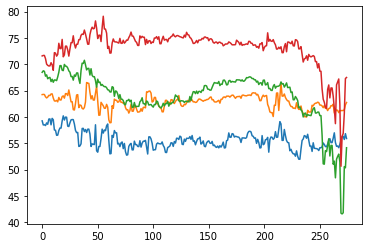

In [12]:
plt.plot(np.concatenate((dim[:, 0], dim[:, 1]), axis=1))

Median dimensions of plates as a percent of the frame.

In [13]:
expectedDim = np.quantile(dim.mean(axis=1), 0.50, axis=0)/RES
expectedDim

array([0.18830075, 0.21401027])

Coefficients to convert x and y units into meters.

In [14]:
coef = 0.450/expectedDim
print(coef)
center_m = np.multiply(center, coef)

[2.389794   2.10270282]


Remove abnormally small segmentations or points that make a large jump

In [15]:
np.percentile(diff, 99.9999)

0.03467234840437299

In [16]:
np.percentile(area, [1])

array([2316.68573376])

In [17]:
center_m[area < 100] = np.nan
center_m[diff > 0.1] = np.nan

In [18]:
center_m.shape

(275, 2, 2)

In [19]:
position = center_m.mean(axis=1) - center_m.mean(axis=1).min(axis=0)
position.shape

(275, 2)

This plot includes the inside, outside, and averaged paths.

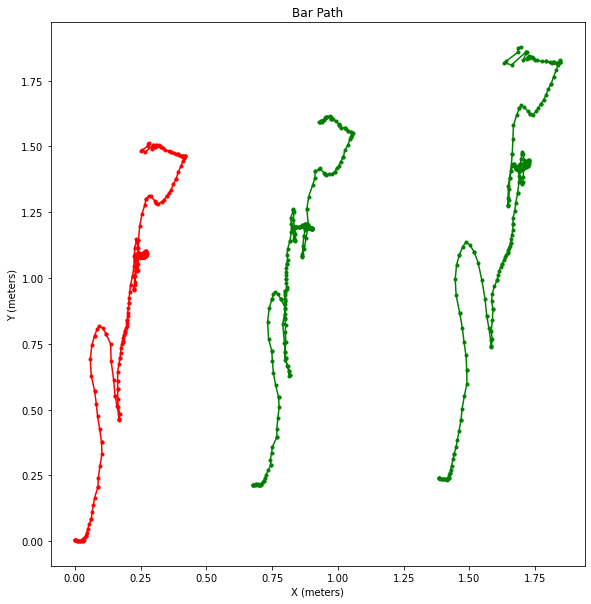

In [20]:
fig = plt.figure(facecolor='w', figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

plt.plot(position[:, 0], position[:, 1], marker='.', color = 'red')
plt.plot(center_m[:, :, 0], center_m[:, :, 1], marker='.', color='green')

ax.set_title('Bar Path')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')

#plt.savefig('output.png', transparent=False, dpi = 100, bbox_inches='tight')
plt.show()

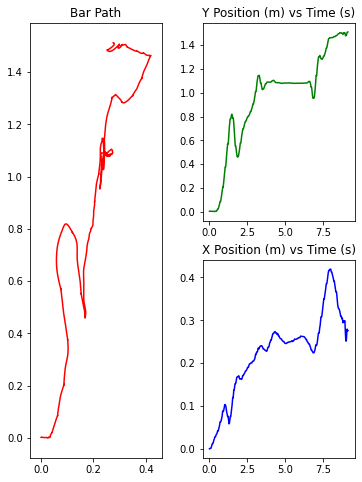

In [21]:
# create time series
length = np.round(frameCount/frameRate, 2)
t = np.linspace(0, length, frameCount)
td = 0.01
tn = np.arange(0, length, td)

# create spline
splinefn = interpolate.interp1d(t, position, axis=0, kind='cubic',)

# make subplots
x = splinefn(tn)[:, 0]
y = splinefn(tn)[:, 1]

plt.figure(figsize=(6, 8), facecolor='w')
ax1 = plt.subplot(121)
ax1.margins(x=0.1)
ax1.set_aspect('equal')
ax1.plot(x, y, color = 'red')
ax1.set_title('Bar Path')

ax2 = plt.subplot(222)
ax2.plot(tn, y, color='green')
ax2.set_title('Y Position (m) vs Time (s)')

ax3 = plt.subplot(224)
ax3.plot(tn, x, color='blue')
ax3.set_title('X Position (m) vs Time (s)')

plt.savefig('output.png', transparent=False, dpi = 100, bbox_inches='tight')

In [22]:
vel = np.diff(splinefn(tn), axis=0)/td

# create velocity spline
vel_splinefn = interpolate.interp1d(tn[1:], vel, axis=0, kind='cubic',)

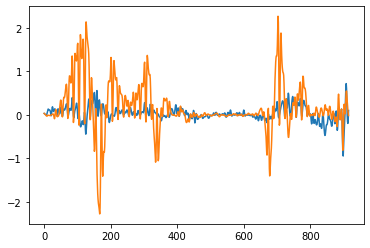

In [23]:
plt.plot(vel)

In [24]:
combined = video.numpy().copy()
#combined[:, :2][mask[:, :2] > 0.01] = mask[:, :2][mask[:, :2] > 0.01]/2
combined = combined*255
combined = combined.astype(np.uint8)
combined = np.swapaxes(combined, 1, -1)
combined = np.swapaxes(combined, 1, 2)

imgs = []
for idx, img in enumerate(combined):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)

    cx = center[idx, :, 0]*RES
    cy = (1 - center[idx, :, 1])*RES

    draw.line([(cx[0], cy[0]), (cx[1], cy[1])], fill=(0, 0, 255), width=2)

    size = 5
    inside = (cx[0] - size, cy[0] - size, cx[0] + size, cy[0] + size)
    outside = (cx[1] - size, cy[1] - size, cx[1] + size, cy[1] + size)

    draw.ellipse(inside, fill=(0, 200, 0))
    draw.ellipse(outside, fill=(0, 200, 0))

    draw.ellipse(np.mean((inside, outside), axis=0).tolist(), fill=(255, 0, 0))

    imgs.append(img)

In [25]:
imgs[0].save("test_out.gif", save_all=True, append_images=imgs[::2], duration=2*1000/frameRate, loop=0)

<img src="test_out.gif" width="500" align="center"> 